In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})

import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [2]:
from datetime import datetime
now = datetime.now()
now_ = datetime(now.year, now.month, now.day)
## 9990010000070044
# sample with minus

q = '''

select 
    ttdr.tbtdr_created_date, 
    ttdr.tbtdr_ponta_user AS TRO_MEMBERS, 
    ttdr.tbtdr_tbto_id, 
    ttdr.tbtdr_rating AS rating
from 
    tb_transaction_delivery_rating ttdr 
where 
    ttdr.tbtdr_created_date between '2021-09-01' and '2021-12-01'
    and ttdr.tbtdr_rating > 0
'''.format(now_)

con, cur = ds_db.connect_prd_order_4()
df_re = pd.read_sql(q, con)


con.close()

df_re['created_date'] = df_re['tbtdr_created_date'].dt.strftime('%Y-%m')
df_re = df_re[df_re['tro_members'] != '']
# df_re_g = df_re.groupby(['tro_members','created_date']).agg({'rating':'mean'})

df_re_g = df_re.groupby(['tro_members', 'created_date']).agg(
                                        rating_below = ('rating', lambda x: len(x[x<3])),
                                        rating_avg = ('rating','mean')
                            )
df_re_g_u = df_re_g.unstack(level=1).fillna(0).reset_index()
df_re_g_u.columns = [' '.join(col).strip().upper() for col in df_re_g_u.columns.values]

df_re_g_u.head(20)

You are connected


,TRO_MEMBERS,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,9990010000069277,0.0,0.0,0.0,5.0,0.0,0.0
1,9990010000070044,0.0,0.0,0.0,5.0,0.0,0.0
2,9990010000089999,0.0,0.0,0.0,0.0,5.0,0.0
3,9990010000191790,0.0,0.0,0.0,0.0,5.0,0.0
4,9990010000196641,0.0,0.0,0.0,5.0,5.0,0.0
5,9990010000198083,0.0,0.0,0.0,0.0,5.0,0.0
6,9990010000208214,0.0,0.0,0.0,5.0,5.0,0.0
7,9990010000209455,0.0,0.0,0.0,5.0,0.0,0.0
8,9990010000209683,0.0,0.0,1.0,0.0,5.0,1.0
9,9990010000212946,0.0,0.0,0.0,0.0,5.0,0.0


In [3]:
df_re['tbtdr_created_date'].min(), df_re['tbtdr_created_date'].max()

(Timestamp('2021-09-01 00:16:15.200000'),
 Timestamp('2021-11-30 23:51:16.002000'))

In [4]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-07-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Jul21 01Aug21
01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [5]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')
df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-08-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [6]:
# df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
#                         .agg({'TRO_NET':'sum',
#                               'TRO_VOUCHER_USAGE':'sum'})

df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum','TRO_NO_ORDER':'nunique'})

In [7]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

In [8]:
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

In [9]:
df_tto_re.head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,006506519712,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,3217556.0,15.0,20.0,35.0,49.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9990010000001771,82453.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000001999,86132.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
condition = ( 
          (df_tto_re['TRO_NET 2021-09'] > 0) & \
          (df_tto_re['TRO_NET 2021-10'] > 0) & \
          (df_tto_re['TRO_NET 2021-11'] > 0) & \
          (df_tto_re['TRO_NET 2021-12'] == 0) 
)
df_tto_re['label'] = np.where(condition, 1, 0)

In [11]:
df_tto_re[df_tto_re['label'] == 1].head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,label
22,9990010000079873,390266.0,565660.0,150542.0,129998.0,0.0,6.0,18.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
31,9990010000107760,488072.0,206812.0,191632.0,67635.0,0.0,7.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
48,9990010000191790,66816.0,297814.0,55000.0,126817.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1
49,9990010000196641,20726197.0,377351.0,47179.0,48543.0,0.0,147.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,1
63,9990010000205973,628400.0,386600.0,600100.0,756900.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [12]:
df_tto_re[df_tto_re['label'] == 0].head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,label
0,006506519712,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,3217556.0,15.0,20.0,35.0,49.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,9990010000001771,82453.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,9990010000001999,86132.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

X = df_tto_re.iloc[:,1:-1].drop(['TRO_NET 2021-12', 'TRO_NO_ORDER 2021-12'], 1)
y = df_tto_re['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    217537
           1       0.44      0.00      0.00      5800

    accuracy                           0.97    223337
   macro avg       0.71      0.50      0.49    223337
weighted avg       0.96      0.97      0.96    223337



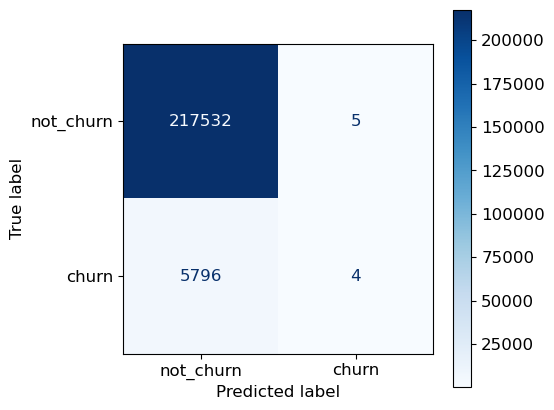

In [14]:
clf_ridge = RidgeClassifier() 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    217537
           1       0.00      0.00      0.00      5800

    accuracy                           0.97    223337
   macro avg       0.49      0.50      0.49    223337
weighted avg       0.95      0.97      0.96    223337



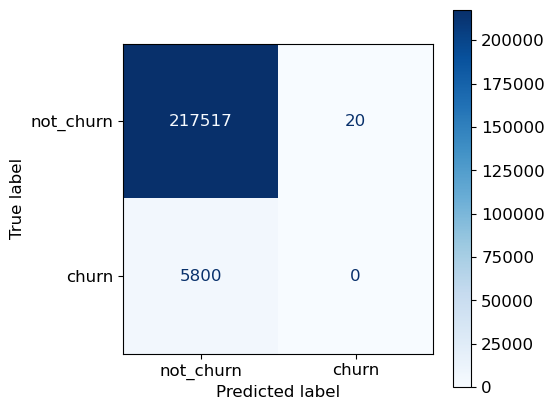

In [15]:
clf_ridge = LogisticRegression()  
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    217537
           1       0.31      0.06      0.10      5800

    accuracy                           0.97    223337
   macro avg       0.64      0.53      0.54    223337
weighted avg       0.96      0.97      0.96    223337



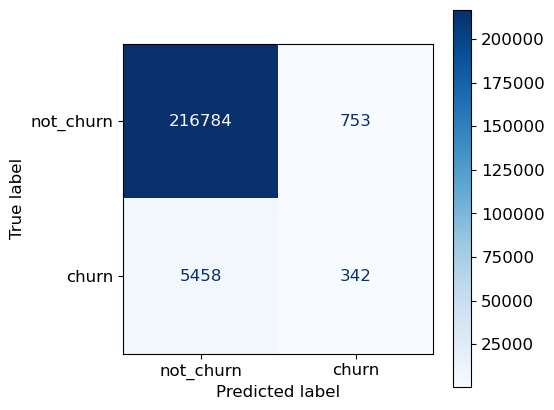

In [16]:
clf_ridge = DecisionTreeClassifier(random_state=0, max_depth=15) 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)
# from sklearn.tree import export_text
# r = export_text(clf_ridge, feature_names=list(X_train), decimals=0, spacing=6)
# print("prediction rule \n{}".format(r))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    217537
           1       0.43      0.09      0.15      5800

    accuracy                           0.97    223337
   macro avg       0.70      0.54      0.57    223337
weighted avg       0.96      0.97      0.96    223337



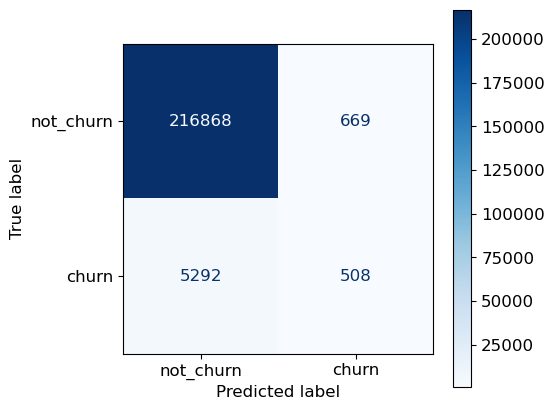

In [17]:
clf_ridge = RandomForestClassifier(max_features='sqrt') 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [28]:
cr = classification_report(y_test, pred, output_dict=True)
cr['macro avg']['f1-score']

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_sample(X_train, y_train)

0.5660321320292996

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
def randomForest_fit(x_train, y_train, scoring = 'f1_macro'):
    randomForest = RandomForestClassifier(random_state=123)

    hyperparam = {'min_samples_leaf': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
                  'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75], 
                  'n_estimators': [100, 200, 300, 500, 750, 1000]}
    
#     random_randomForest = RandomizedSearchCV(randomForest, param_distributions = hyperparam, cv = 5, 
#                                            n_iter = 6, scoring = scoring, n_jobs=-1, random_state = 123) 
#     to long running time
    random_randomForest = GridSearchCV(randomForest, param_grid = hyperparam, cv = 5, 
                                        scoring = scoring, n_jobs=32)
    random_randomForest.fit(x_train, y_train)
    
    print ("Best F1", random_randomForest.best_score_)
    print ("Best Param", random_randomForest.best_params_)
    return random_randomForest

best_randForest = randomForest_fit(X, y)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    217537
           1       0.47      0.04      0.08      5800

    accuracy                           0.97    223337
   macro avg       0.72      0.52      0.53    223337
weighted avg       0.96      0.97      0.96    223337



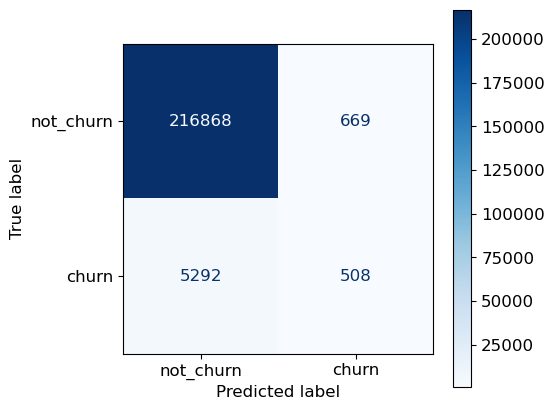

In [35]:
randForest = RandomForestClassifier(random_state=123, n_jobs = -1,
                                   min_samples_leaf = best_randForest.best_params_.get('min_samples_leaf'),
                                   max_features = best_randForest.best_params_.get('max_features'),
                                   n_estimators = best_randForest.best_params_.get('n_estimators'))
name = randForest.__class__.__name__
randForest.fit(X_train, y_train) 
pred = randForest.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [18]:
# coba cek master member
# join dengan member id yang 8 angka
# cari create date dengan member yang terbaru

In [19]:
import cx_Oracle
from sqlalchemy import event,create_engine,types

driver = 'cx_oracle'
server = '10.234.152.61' 
database = 'alfabi' 
username = 'report' 
password = 'justd0it'
engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

engine = create_engine(engine_stmt)

df = df_tto_re[['TRO_MEMBERS']]
dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

engine.dispose()

In [20]:
# li_df_pv = []

# for dr in pd.date_range('2021-11-01', '2021-11-30'):
#     df_f = dr.strftime('%d-%b-%y')
#     q = '''
#     SELECT 
#         tc.TRO_MEMBERS, d
#         count(ame.AME_CART_PRODUCT_ID) AS COUNT_VIEW_PRODUCT
#     FROM 
#         TEMP_CHURN tc
#         LEFT JOIN PLMS_MEMBER_PROFILE pmp 
#         ON pmp.PMP_MEMBER_ID = tc.TRO_MEMBERS 
#         LEFT JOIN ALFAGIFT_MOE_EVENTS ame 
#         ON ame.AME_PONTA_ID = pmp.PMP_MEMBER_UNIQUE_ID 
#         LEFT JOIN ALFAGIFT_MASTER_PRODUCT amp 
#         ON amp.PRODUCT_ID = ame.AME_CART_PRODUCT_ID 
#     WHERE 
#         TRUNC(ame.AME_EVENT_TIME) BETWEEN '{}' AND '{}'
#         AND ame.AME_EVENT_NAME = 'view_product'
#     GROUP BY tc.TRO_MEMBERS

#     '''.format(df_f, df_f)
#     con = ds_db.connect_alfabi()
#     df_pv = pd.read_sql_query(q, con)
#     con.close()
#     li_df_pv.append(df_pv)
    
# df_pv.head(20)